In [55]:
import pandas as pd

# define some paths
DATASET_B_PATH_LINUX = '/media/chuang/LC/大学/第40期PRP/特征提取/DATASET-B.csv'
DATASET_B_PATH_WIN = 'F:/大学/第40期PRP/特征提取/DATASET-B.csv'


In [56]:
data_total = pd.read_csv(DATASET_B_PATH_WIN)


In [58]:
data = data_total.loc[(data_total.row_id >= ROW_LIM_DOWN)&(data_total.row_id <= ROW_LIM_UP) &(data_total.col_id >= COL_LIM_DOWN) & (data_total.col_id <= COL_LIM_UP)]

In [59]:
# 转换数据类型
for c in ['row_id', 'col_id', 'time_id']:
    data[c] = data[c].astype(int)
data = data.sort_values(['date', 'row_id', 'col_id', 'time_id']).reset_index(drop=True)
data['date']-=data['date'].min()

ipykernel_launcher:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [60]:
# 计数统计
print(len(data[['row_id', 'col_id']].drop_duplicates()), #数据集中包含空间网格数量：即有车经过的网格
    (data.row_id.max() + 1)*(data.col_id.max() + 1))    # 空间网格总数

print(data.groupby(['row_id', 'col_id']).time_id.nunique().mean(), # 各空间网格平均包含的时间段数量
data.time_id.max() + 1) # 时间段总数

2769 -9215
192.62332972192127 306


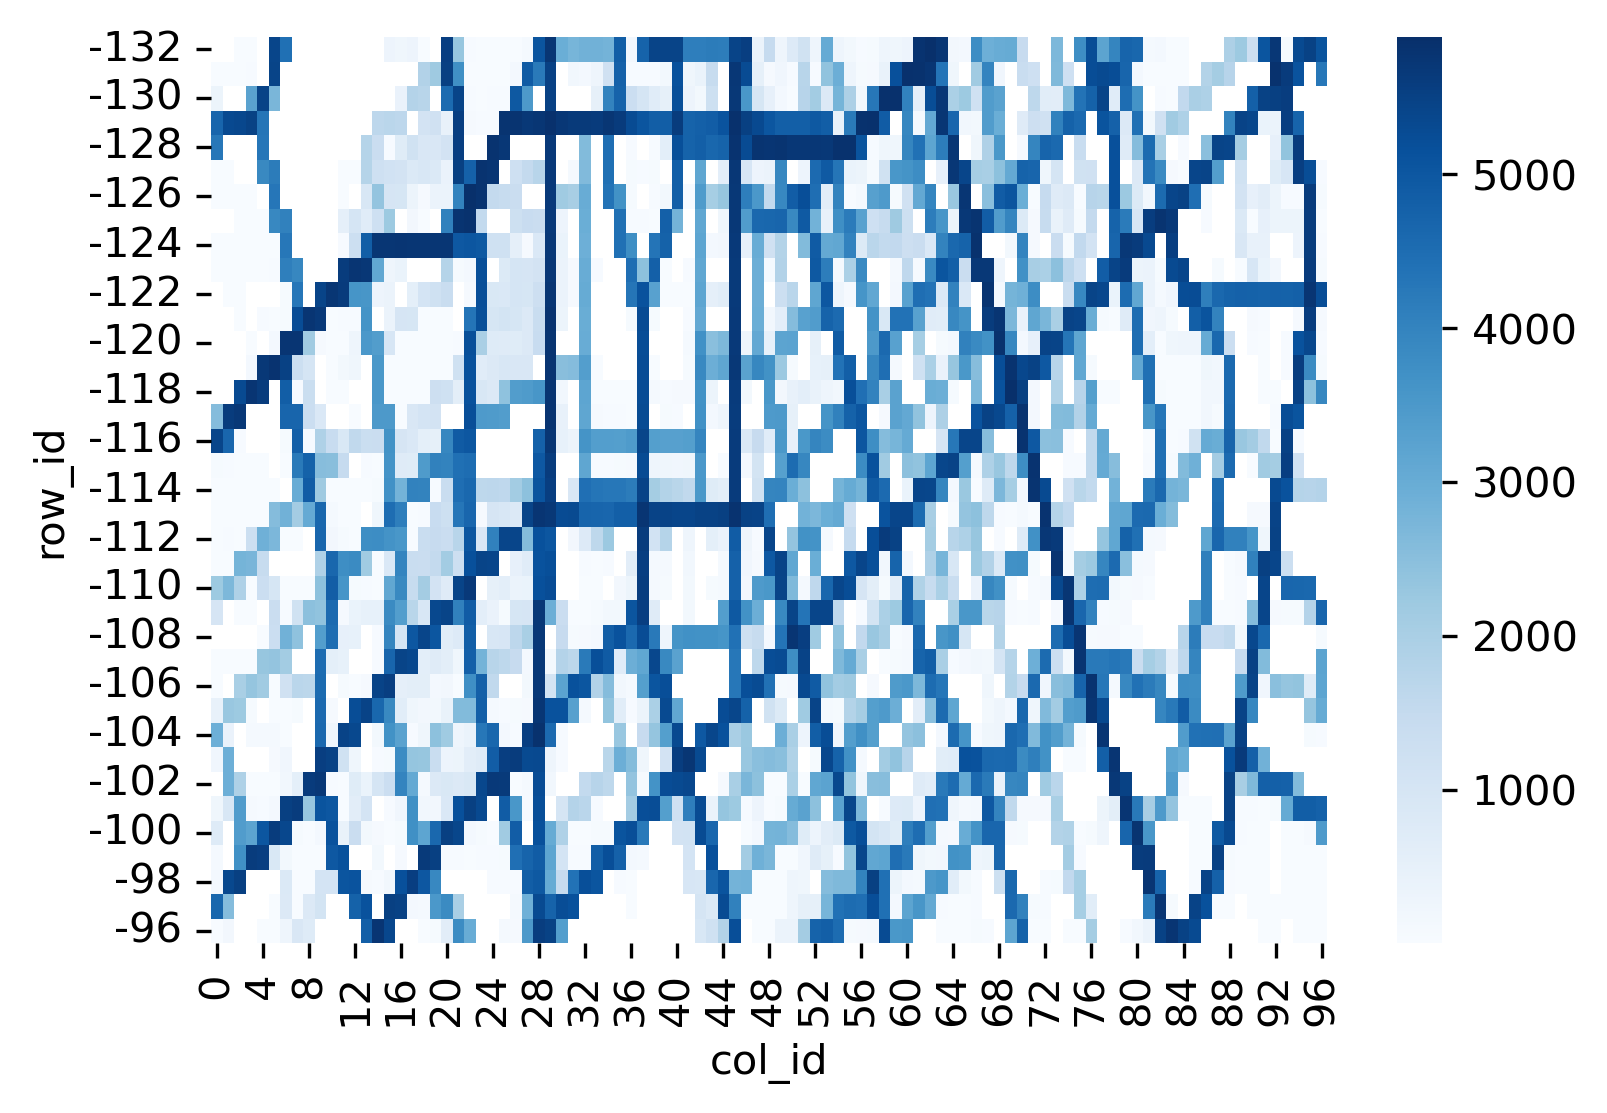

In [61]:
# 可视化：数据的空缺情况
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(dpi=300)
sns.heatmap(data.groupby(['row_id', 'col_id']).size().reset_index(name='volume').pivot_table('volume', 'row_id', 'col_id'), cmap='Blues')
plt.show()

In [62]:
# 处理缺失值：对缺失值填充0（以保证数据的完整性）
# 定义函数grid_recovery: 自动填充缺失的时空网格，并对空值作补0操作

def grid_recovery(df_, cols=[], lens=[]):
    df = df_.copy()
    lcols = len(cols)
    llens = len(lens)
    
    if lcols != llens: # 确保输入的网格名称和网格长度信息的长度一致
        raise ValueError(f'Lengths of cols ({lcols}) and lens ({llens}) mismatch.')
    
    recovery_df = None
    for c, l in zip(cols, lens):
        tmp_df = pd.DataFrame({c:range(l)})
        tmp_df['flag'] = True
        if recovery_df is None:
            recovery_df = tmp_df.copy()
        else:
            recovery_df = recovery_df.merge(tmp_df, 'left', 'flag')
    
    del recovery_df['flag']
    df = recovery_df.merge(df, 'left', cols)
    df = df.fillna(0)
    return df


In [63]:
data_r = grid_recovery(data, ['date', 'row_id', 'col_id', 'time_id'], [NDATE, NROWS, NCOLS, NTIME])
for c in ['volume', 'stopNum']:
    data[c] = data[c].astype(int)

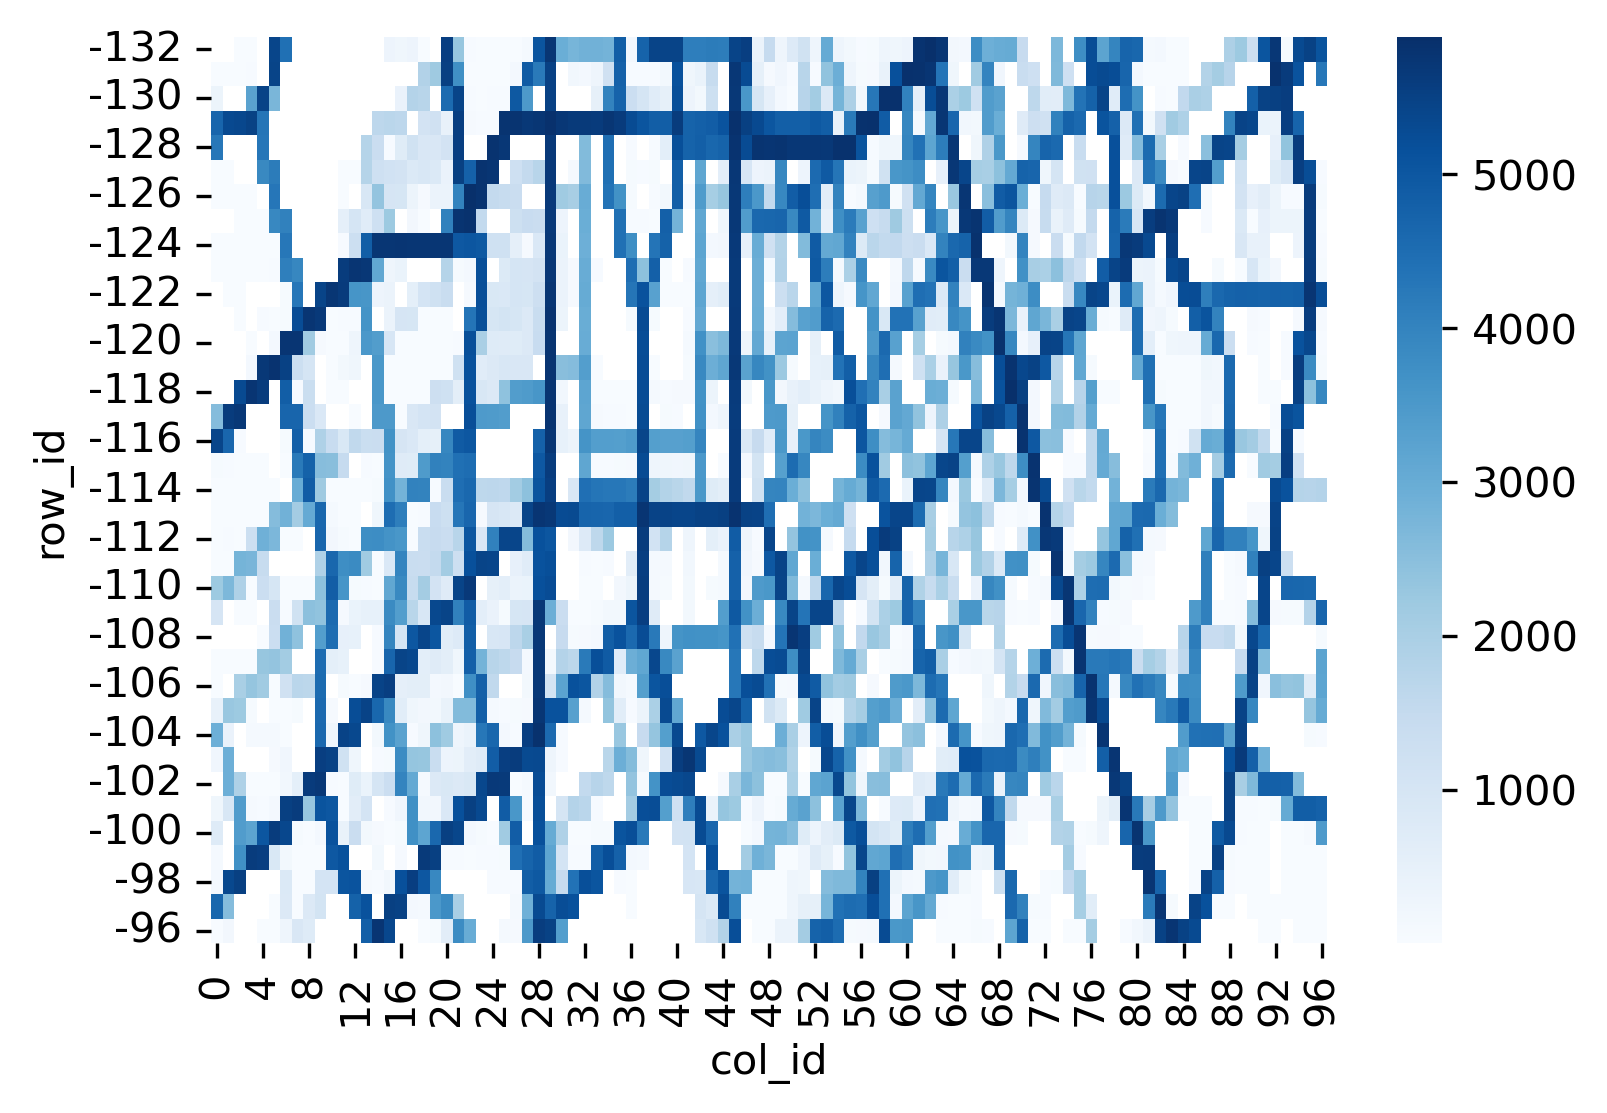

In [64]:
plt.figure(dpi=300)
sns.heatmap(data.groupby(['row_id', 'col_id']).size().reset_index(name='volume').pivot_table('volume', 'row_id', 'col_id'), cmap='Blues')
plt.show()

In [65]:
# 合并时间和空间网格，增大颗粒度，缩小数据扰动
data['hourid'] = data['time_id'] // 6
data['new_rowid'] = data['row_id'] // 2
data['new_colid'] = data['col_id'] // 2
volume = data.groupby(['date', 'new_rowid', 'new_colid', 'hourid'])
volume.sum().reset_index()
volume.columns = ['date', 'row_id', 'col_id', 'hourid', 'volume']

### The codes below are for RNNs

In [66]:
import matplotlib.pyplot as plt

In [67]:
# 1.建模预处理
# 提取待预测的原始数据，并统计该网格中的各项数据

# 数据范围内主要交通流参数随时间变化的曲线
data['seqid'] = data.date * 144 + data.time_id
core_data = data.loc[data.new_rowid.eq(-61) & data.new_colid.eq(19)].reset_index(drop=True) #提取new_rowid为-61、new_colid为19的网格的待预测数据
agg_funcs = {'volume': 'sum', 'aveSpeed': 'mean', 'gridAcc': 'mean', 'speedStd':'mean', 'hourid':'mean', 'date':'mean', 'time_id':'mean'}
ts = core_data.groupby('seqid').agg(agg_funcs).reset_index() #统计各项特征，建立时间序列


<Figure size 432x288 with 0 Axes>

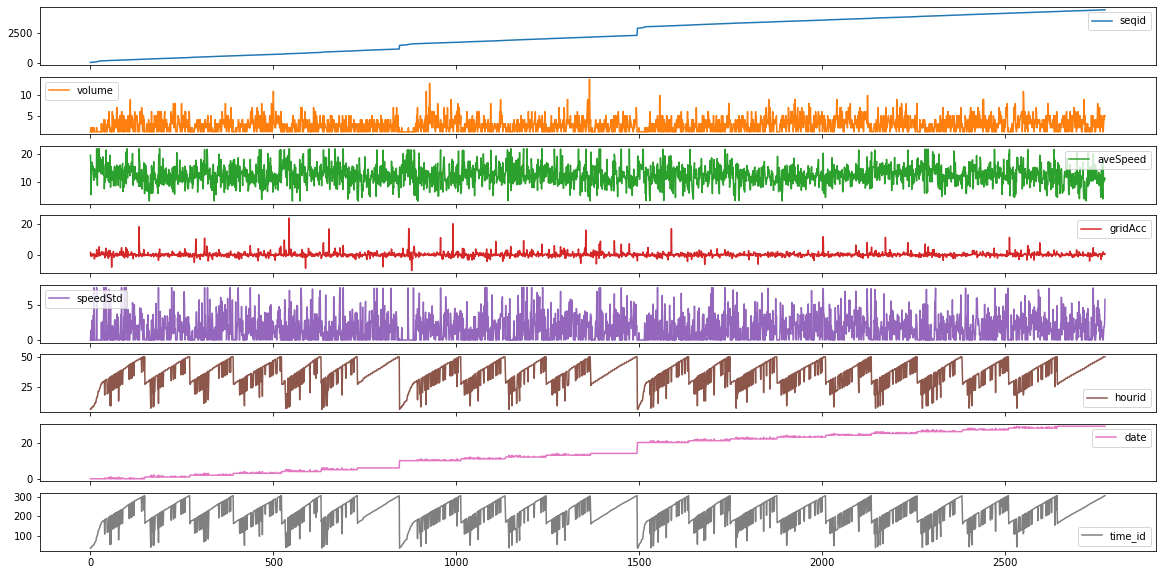

In [68]:
plt.figure()
ts.plot(subplots=True, figsize=(20, 10)); plt.legend(loc='best')

In [69]:
# 取出最后五天的数据作为数据集
# 时间序列的时间粒度为10分钟
# 五天总共有7200分钟，所以我们取时间序列的最后720个数据作为训练集数据
# 使用Scikit-learn中的MinMaxScalar对它们进行归一化的处理


from sklearn.preprocessing import MinMaxScaler    
train_ts = ts[:-5*144].reset_index(drop=True)[[    
    'volume', 'aveSpeed', 'gridAcc', 'speedStd', 'hourid']] # 提取训练集序列    
test_ts = ts[-5*144:].reset_index(drop=True)[[    
    'volume', 'aveSpeed', 'gridAcc', 'speedStd', 'hourid']] # 提取测试集序列    
y_true_test = test_ts.values[..., 0]   # 测试集预测值真值    
scaler = MinMaxScaler()     # 初始化归一化工具    
scaler.fit(train_ts.values) # 读取数据最值信息    
train_ts = pd.DataFrame(scaler.transform(train_ts), columns=train_ts.columns) # 归一化训练集    
test_ts = pd.DataFrame(scaler.transform(test_ts), columns=test_ts.columns)    # 归一化测试集    


D:\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
D:\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


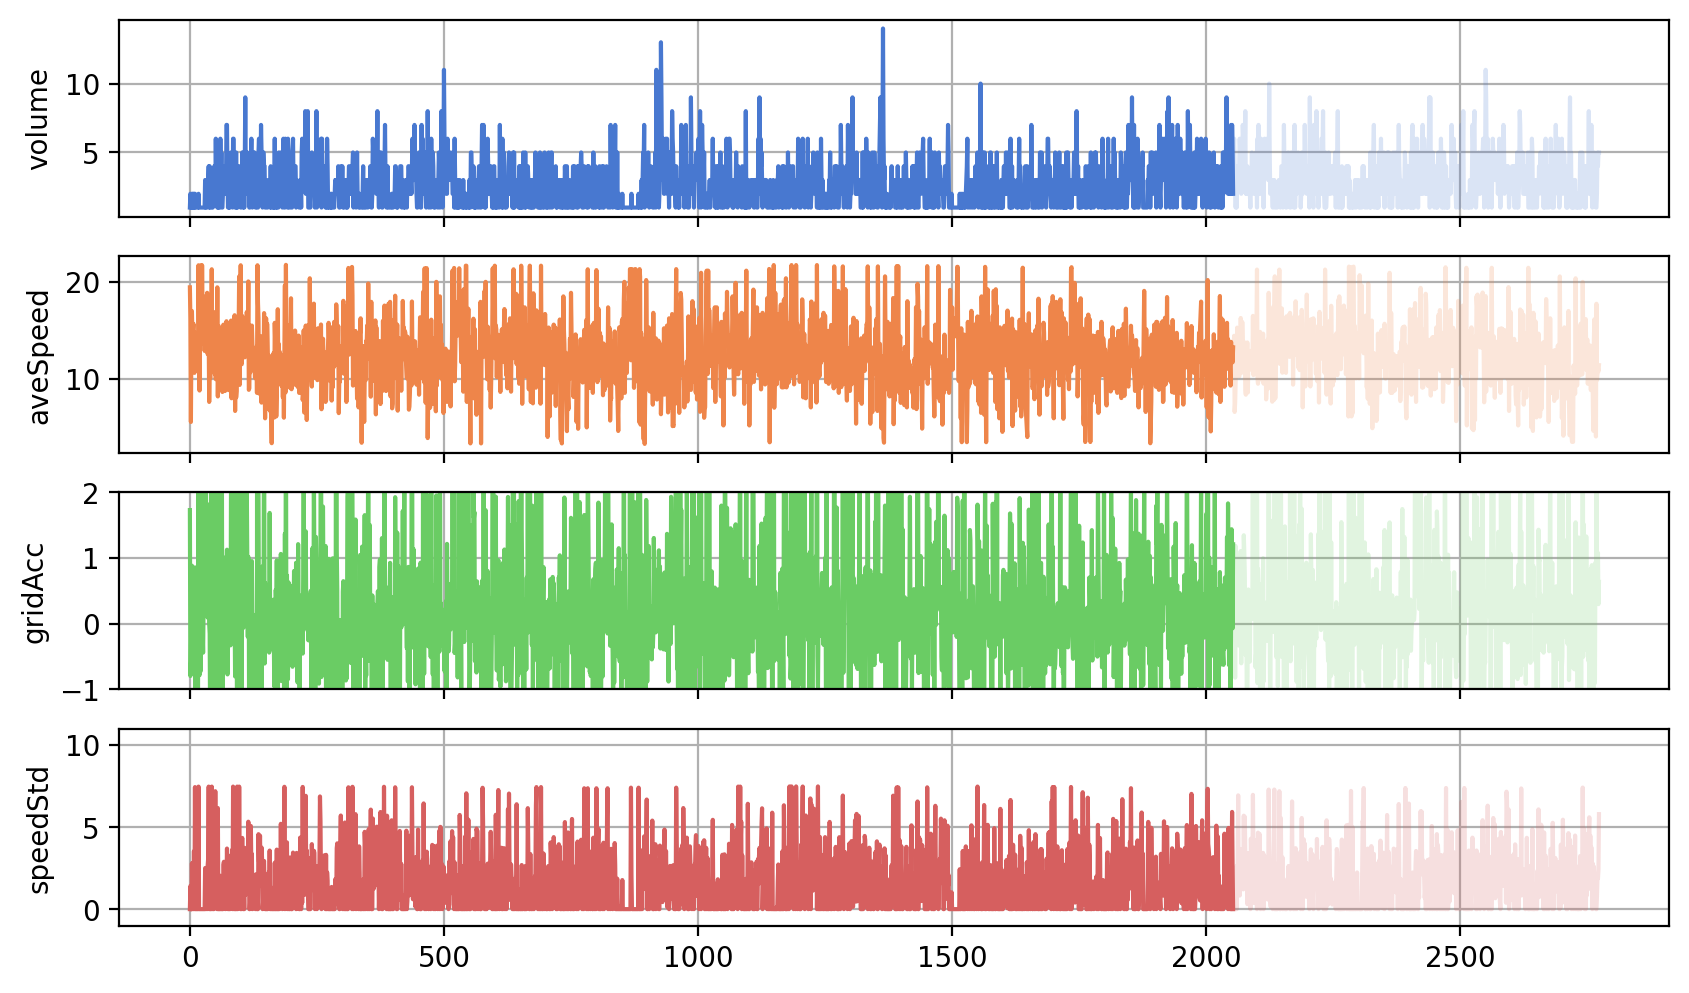

In [70]:
import matplotlib.pyplot as plt  
import seaborn as sns  
fig,ax = plt.subplots(4, 1, figsize=(10, 6), dpi=200, sharex=True)
for idx, (f, c) in enumerate(zip(['volume', 'aveSpeed', 'gridAcc', 'speedStd'], sns.color_palette('muted'))):
    sns.lineplot(x=ts[:-5*144].index, y=f, data=ts[:-5*144], color=c, ax=ax[idx])
    sns.lineplot(x=ts[-5*144:].index, y=f, data=ts[-5*144:], ax=ax[idx], color=c, alpha=0.2)
    ax[idx].grid()
    if idx == 2:
        ax[idx].set_ylim(-1, 2)
    elif idx == 3:
        ax[idx].set_ylim(-1, 11)

In [71]:
import numpy as np
from sklearn.model_selection import train_test_split  
# 将时间序列预测转换为监督学习问题. 
def ts_to_supervise(ts, window, forecast):  
    """ 
    ts: 原始时间序列 
    window: 输入时间步数量 
    forecast: 输入时间步数量 
    """  
    past = []   # 存储输入的时间序列值  
    future = [] # 存储输出的时间序列值  
    for i in range(len(ts) - window - forecast + 1):  
        past.append(ts[i:i+window])  
        future.append(ts[i+window:i+window+forecast])  
    return np.stack(past), np.stack(future)  
ts_x, ts_y = ts_to_supervise(pd.concat([train_ts, test_ts]).values, 7*144, 1)  
train_X, test_X, train_y, test_y = train_test_split(    
    ts_x, ts_y, test_size=len(test_ts), shuffle=False) # 测试集划分 

In [72]:
# 建立模型
import tensorflow as tf  
from tensorflow.keras.models import Model  
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional  
# 设定随机种子  
SEED = 233  
np.random.seed(SEED)  
tf.random.set_seed(SEED)  
# 循环神经网络模型
def rnn_model(input_shape):  
    inputs = Input(shape=input_shape)  
    x = LSTM(15)(inputs)  
    x = Dense(8)(x)  
    x = Dense(1)(x)  
    model = Model(inputs=inputs, outputs=x) # 建立模型  
    return model  
model = rnn_model(train_X.shape[1:]) # 实例化模型 

In [73]:
#模型训练
from tensorflow.keras import optimizers  
from tensorflow.keras.callbacks import EarlyStopping  
batch_size = 16 # 每一训练批次的样本数量  
epochs = 50     # 最大训练轮数  
opt = optimizers.Adam(learning_rate=0.001) # 优化器  
model.compile(loss='mse',  
              optimizer=opt,  
              metrics=['mae', 'mse'])  
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20) # 早停策略  
history = model.fit(  
    train_X, train_y[..., 0],  
    batch_size=batch_size,  
    epochs=epochs,  
    validation_split=0.15, # 验证集比例  
    use_multiprocessing=True, # 使用多线程  
    callbacks=[early_stopping]) # 训练模型  

Epoch 1/50
56/56 [==============================] - 10s 176ms/step - loss: 0.0168 - mae: 0.0984 - mse: 0.0168 - val_loss: 0.0260 - val_mae: 0.1231 - val_mse: 0.0260
Epoch 2/50
56/56 [==============================] - 10s 171ms/step - loss: 0.0142 - mae: 0.0911 - mse: 0.0142 - val_loss: 0.0219 - val_mae: 0.1155 - val_mse: 0.0219
Epoch 3/50
56/56 [==============================] - 9s 168ms/step - loss: 0.0139 - mae: 0.0893 - mse: 0.0139 - val_loss: 0.0210 - val_mae: 0.1143 - val_mse: 0.0210
Epoch 4/50
56/56 [==============================] - 9s 168ms/step - loss: 0.0138 - mae: 0.0902 - mse: 0.0138 - val_loss: 0.0276 - val_mae: 0.1259 - val_mse: 0.0276
Epoch 5/50
56/56 [==============================] - 9s 166ms/step - loss: 0.0139 - mae: 0.0898 - mse: 0.0139 - val_loss: 0.0227 - val_mae: 0.1166 - val_mse: 0.0227
Epoch 6/50
56/56 [==============================] - 9s 169ms/step - loss: 0.0140 - mae: 0.0903 - mse: 0.0140 - val_loss: 0.0210 - val_mae: 0.1144 - val_mse: 0.0210
Epoch 7/50
56/

In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error  
pred_test = model.predict(test_X) # 预测测试集数据  
inv_test_ts = test_ts.copy()  
inv_test_ts.volume = pred_test  
y_hat_test = scaler.inverse_transform(inv_test_ts)[:, 0] # 还原归一化  
print(mean_absolute_error(y_true_test, 2*y_hat_test),   
      mean_squared_error(y_true_test, 2*y_hat_test),   
      np.sqrt(mean_squared_error(y_true_test, 2*y_hat_test)))

2.5742475611882076 8.523473819698156 2.919498898732136


In [46]:
fig,ax = plt.subplots(1, 1, figsize=(10, 2), dpi=200, sharex=True)
c = sns.color_palette('muted')
sns.lineplot(x=ts[:-5*144].index, y='volume', data=ts[:-5*144], color=c[0], ax=ax, label='真实值')
sns.lineplot(x=ts[-5*144:].index, y='volume', data=ts[-5*144:], ax=ax, color=c[0], alpha=0.3)
sns.lineplot(x=ts[-5*144:].index, y=y_hat_test, ax=ax, color=c[1], label='预测值')
ax.legend(prop=fp)
ax.set_xlim(-50, len(ts) + 50)
ax.set_ylabel('volume')
ax.grid()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'f:\\usr\\share\\fonts\\opentype\\noto\\NotoSansCJK-Regular.ttc'

<Figure size 2000x400 with 1 Axes>

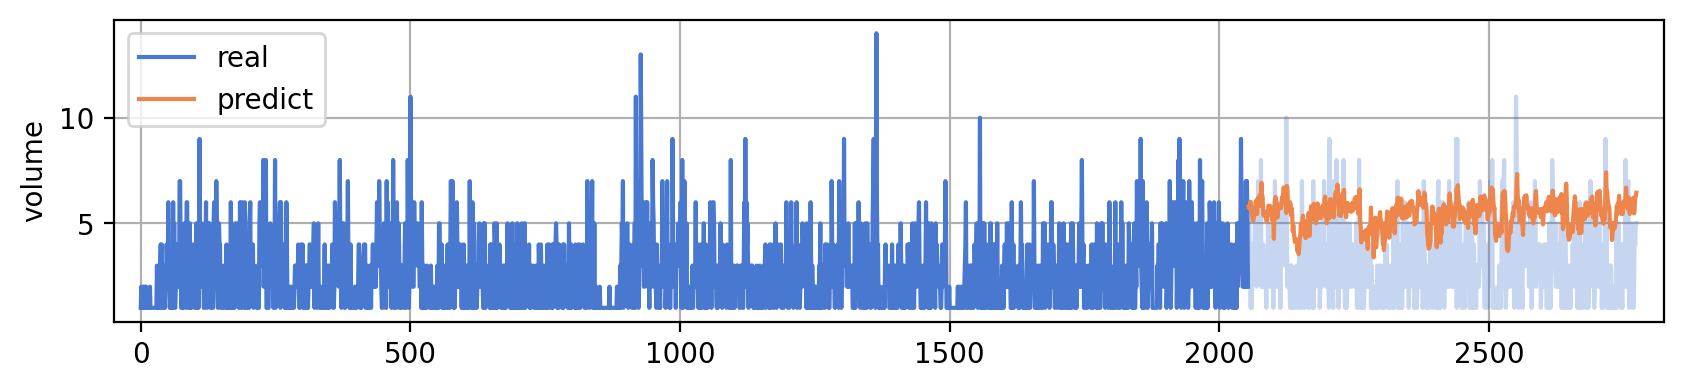

In [75]:
fig,ax = plt.subplots(1, 1, figsize=(10, 2), dpi=200, sharex=True)
c = sns.color_palette('muted')
sns.lineplot(x=ts[:-5*144].index, y='volume', data=ts[:-5*144], color=c[0], ax=ax, label='real')
sns.lineplot(x=ts[-5*144:].index, y='volume', data=ts[-5*144:], ax=ax, color=c[0], alpha=0.3)
sns.lineplot(x=ts[-5*144:].index, y=2*y_hat_test, ax=ax, color=c[1], label='predict')
ax.set_xlim(-50, len(ts) + 50)
ax.set_ylabel('volume')
ax.grid()
plt.show()